# Comparing the Downstream Analysis

In [1]:
import os
import sys
import feather
import warnings

import numpy as np # Numerical computing
import pandas as pd # Data manipulation

import seaborn as sns # R-like high-level plots
import matplotlib.pyplot as plt # Python's base plotting 
from scipy import stats # Statistical library
from sklearn.decomposition import PCA # PCA from scikit-learn

sys.path.append('../')
from src import utils, plots, tests, enrich

warnings.filterwarnings('ignore')

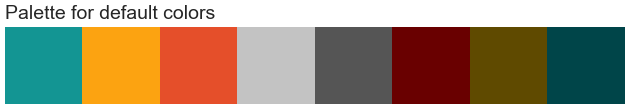

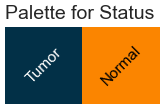

In [2]:
# Create a dictionary for a greyscale color palette with 9 colors
def_colors = [
    "#139593", "#fca311", "#e54f2a",
    "#c3c3c3", "#555555",
    "#690000", "#5f4a00", "#004549"
]

status_colors = {
    "Tumor": "#023047",
    "Normal": "#fb8500",
}
regulation_colors = {
    'Up': "#023047",
    'Down': '#fb8500'
}

# Set seaborn style
sns.set_theme(
    style="white",
    context="paper",
    palette=def_colors,
    font_scale=1,
    rc={
        "figure.figsize": (6, 4),
        "font.family": "sans-serif",
        "font.sans-serif": ["Arial"],
    }
)

# Figure Saving Settings
figure_formats = ["pdf"]
save_to_folder = True
transparet_bg = True
figure_dpi = 300

## Configure dataframe displaying
pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', 25)

plots.color_palette(
    def_colors, 
    save=False
)
plots.color_palette(
    status_colors,
    name="Status",
    save=False
)

In [3]:
notebook_name = "9_DownstreamComparison"
data_path = "./data/processed/"
input_path = f"./data/results/"
output_path = f"./data/results/{notebook_name}/"
figure_path = f"./figures/{notebook_name}/"

# Create the output folder if it does not exist
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Create figure folder structure, if needed
if save_to_folder:
    for i in figure_formats:
        cur_folder = figure_path + i + "/"
        if not os.path.exists(cur_folder):
            os.makedirs(cur_folder)

## Load the data

### Metadata

In [4]:
# Open the feather file
metadata = feather.read_dataframe(f"{data_path}MatchedPatient_TumorNormal_Metadata.feather")
utils.print_shape(metadata, "Metadata")
metadata.head()

Metadata data has 20 rows and 15 columns


,Filename,Date,Samples,Slot,UniqueNames,BCCHR ID,ID,Group,Differentiation,MKI,INPC,NMYC,Location,Location-Note,Info
9,[67] 20240313_GB_NBL-macro-74_Slot1-58_1_399.h...,20240313,NBL-macro-74,Slot1-58,NBL-macro-74_Slot1-58,74.0000,9.0000,Normal,None,None,None,None,AG,None,True
13,[68] 20240313_GB_NBL-macro-75_Slot1-59_1_400.h...,20240313,NBL-macro-75,Slot1-59,NBL-macro-75_Slot1-59,75.0000,13.0000,Normal,None,None,None,None,AG,None,True
15,[69] 20240313_GB_NBL-macro-76_Slot1-60_1_401.h...,20240313,NBL-macro-76,Slot1-60,NBL-macro-76_Slot1-60,76.0000,14.0000,Normal,None,None,None,None,AG,None,True
36,[71] 20240313_GB_NBL-macro-78_Slot1-62_1_403.h...,20240313,NBL-macro-78,Slot1-62,NBL-macro-78_Slot1-62,78.0000,33.0000,Normal,None,None,None,None,AG,None,True
43,[152] 20240322_GB_NBL-macro-80_Slot1-71_1_506....,20240322,NBL-macro-80,Slot1-71,NBL-macro-80_Slot1-71,80.0000,38.0000,Normal,None,None,None,None,AG,None,True


### Expanded Info Data

In [5]:
expanded_info_data = feather.read_dataframe( f"{input_path}expanded_info_data_updated.feather")
expanded_info_data = expanded_info_data[expanded_info_data['ProteoformGroup'] > -1]
proteoform_info = expanded_info_data[[
    "Protein", "Peptide", "PeptideID", 
    "proteinDescription", "geneName", 
    "startpos", "endpos", "seqLength", 
    "trace", "Cov%", "isCAP",
    "adj.pvalue", "TumorRegulation", 
    "isSignificant", "ProteoformGroup"
]].rename(columns={"ProteoformGroup": "pfg"})
# Create Proteoform Groups with at least 2 peptides 
prf_grps = proteoform_info.groupby("Protein")["pfg"].value_counts()
proteoform_info["Proteoform"] = proteoform_info['Protein'] + "_" + proteoform_info['pfg'].astype(int).astype(str)

proteoform_info.set_index(["Protein", "Peptide"], inplace=True)
proteoform_info.head()

PeptideID  \
Protein    Peptide                     
A0A024RBG1 MKFKPNQTR               1   
           TYDREGFK                2   
           SEQEDEVLLVSSSR          3   
           LLGIFEQNQDR             4   
           LLGIFEQNQDRK            5   

                                                          proteinDescription  \
Protein    Peptide                                                             
A0A024RBG1 MKFKPNQTR       Diphosphoinositol polyphosphate phosphohydrola...   
           TYDREGFK        Diphosphoinositol polyphosphate phosphohydrola...   
           SEQEDEVLLVSSSR  Diphosphoinositol polyphosphate phosphohydrola...   
           LLGIFEQNQDR     Diphosphoinositol polyphosphate phosphohydrola...   
           LLGIFEQNQDRK    Diphosphoinositol polyphosphate phosphohydrola...   

                          geneName  startpos  endpos  seqLength  trace  \
Protein    Peptide                                                       
A0A024RBG1 MKFKPNQTR        NUDT4B         1      10        181      0   
           TYDREGFK         NUDT4B        10      18        181      0   
           SEQEDEVLLVSSSR   NUDT4B        27      41        181      0   
           LLGIFEQNQDR      NUDT4B        79      90        181      0   
           LLGIFEQNQDRK     NUDT4B        79      91        181      1   

                             Cov%  isCAP  adj.pvalue TumorRegulation  \
Protein    Peptide                                                     
A0A024RBG1 MKFKPNQTR      23.7569  False      0.0132              Up   
           TYDREGFK       23.7569  False      0.0000            Down   
           SEQEDEVLLVSSSR 23.7569  False      0.0400            Down   
           LLGIFEQNQDR    23.7569  False      0.3053            Down   
           LLGIFEQNQDRK   23.7569  False      0.6194            Down   

                           isSignificant    pfg    Proteoform  
Protein    Peptide                                             
A0A024RBG1 MKFKPNQTR               False 0.0000  A0A024RBG1_0  
           TYDREGFK                 True 1.0000  A0A024RBG1_1  
           SEQEDEVLLVSSSR          False 0.0000  A0A024RBG1_0  
           LLGIFEQNQDR             False 1.0000  A0A024RBG1_1  
           LLGIFEQNQDRK            False 1.0000  A0A024RBG1_1

### Datasets

#### QuEStVar Test Results

In [6]:
dataTypes = {
    "mean(all)Proteins": "#f4d35e",
    "mean(top)Proteins": "#ee964b",
    "SpectranoutProteins": "#f95738",
    "dPFProteins": "#083d77"
}

# Collect the testResults
testResults = {
    "mean(all)Proteins": pd.read_csv(
        f"{input_path}5_meanAllAnalysis/QuEStVar_PairSummary.csv"
    ),
    "mean(top)Proteins": pd.read_csv(
        f"{input_path}6_meanTop3Analysis/QuEStVar_PairSummary.csv"
    ),
    "SpectranoutProteins": pd.read_csv(
        f"{input_path}7_spectranoutAnalysis/QuEStVar_PairSummary.csv"
    ),
    "dPFProteins": pd.read_csv(
        f"{input_path}8_proteoformAnalysis/QuEStVar_PairSummary.csv"
    )
}

print("Test Results:")
for k, v in testResults.items():
    print(f" - {k}: {v.shape}")


Test Results:
 - mean(all)Proteins: (7026, 17)
 - mean(top)Proteins: (6706, 17)
 - SpectranoutProteins: (6726, 17)
 - dPFProteins: (13003, 17)


#### Enrichment Results for Difference and Equivalence Sets

In [7]:
# Load the Enrichment Results
enrichmentResults = {
    "mean(all)Proteins": pd.concat(
        [
            pd.read_csv(f"{input_path}5_meanAllAnalysis/gProf_pval0.001_Difference.csv"),
            pd.read_csv(f"{input_path}5_meanAllAnalysis/gProf_pval0.001_Equivalence.csv")
        ],
        axis=0,
        ignore_index=True
    ),
    "mean(top)Proteins": pd.concat(
        [
            pd.read_csv(f"{input_path}6_meanTop3Analysis/gProf_pval0.001_Difference.csv"),
            pd.read_csv(f"{input_path}6_meanTop3Analysis/gProf_pval0.001_Equivalence.csv")
        ],
        axis=0,
        ignore_index=True
    ),
    "SpectranoutProteins": pd.concat(
        [
            pd.read_csv(f"{input_path}7_spectranoutAnalysis/gProf_pval0.001_Difference.csv"),
            pd.read_csv(f"{input_path}7_spectranoutAnalysis/gProf_pval0.001_Equivalence.csv")
        ],
        axis=0,
        ignore_index=True
    ),
    "dPFProteins": pd.concat(
        [
            pd.read_csv(f"{input_path}8_proteoformAnalysis/gProf_pval0.001_Difference.csv"),
            pd.read_csv(f"{input_path}8_proteoformAnalysis/gProf_pval0.001_Equivalence.csv")
        ],
        axis=0,
        ignore_index=True
    )
}

print("Enrichment Results:")
for k, v in enrichmentResults.items():
    print(f" - {k}: {v.shape}")

Enrichment Results:
 - mean(all)Proteins: (356, 12)
 - mean(top)Proteins: (260, 12)
 - SpectranoutProteins: (589, 12)
 - dPFProteins: (1132, 12)


# Comparing the Downstream Analysis

## Protein Level Numbers

### Reproducibility at Biological Samples

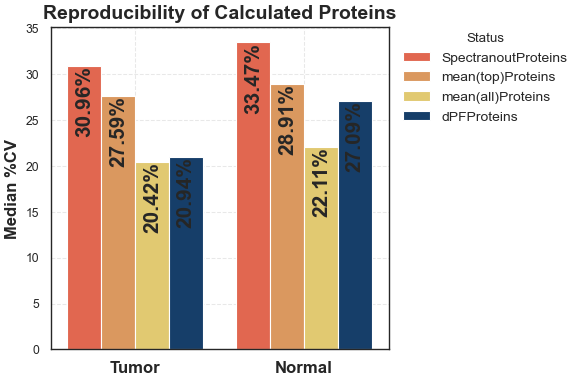

In [8]:
cvComparison = {
    "SpectranoutProteins": {
        "Tumor": 30.9596,
        "Normal": 33.4741
    },
    "mean(top)Proteins": {
        "Tumor": 27.5945,
        "Normal": 28.9076
    },
    "mean(all)Proteins": {
        "Tumor": 20.4153,
        "Normal": 22.1113
    },
    "dPFProteins": {
        "Tumor": 20.9437,
        "Normal": 27.0858
    }
}
plot_data = pd.DataFrame(cvComparison).reset_index().melt(
    id_vars="index",
    var_name="Protein Calculation",
    value_name="%CV"
).rename(
    columns={"index": "Condition"}
)

fig, ax = plt.subplots(figsize=(6, 4))
sns.barplot(
    data=plot_data,
    x="Condition",
    y="%CV",
    hue="Protein Calculation",
    palette=dataTypes,
    ax=ax
)
# Add the percentage as rotated within the bard centered from top
for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.2f}%",
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha="center",
        va="top",
        xytext=(0.5, 0),
        textcoords="offset points",
        rotation=90,
        fontsize=15,
        fontweight="bold"
    )
# xticklabel style
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="center", fontsize=12, fontweight="bold")
ax.set_ylabel("Median %CV", fontsize=12, fontweight="bold")
ax.set_xlabel("", fontsize=12, fontweight="bold")
ax.set_title("Reproducibility of Calculated Proteins", fontsize=14, fontweight="bold")
ax.grid("both", linestyle="--", linewidth=0.75, alpha=0.5, color="lightgrey")
ax.legend(bbox_to_anchor=(1.025, 1), loc=2, borderaxespad=0., fontsize=10, frameon=False, title="Status")
plt.tight_layout()
# Save the figure
plots.save_figures(
    plt.gcf(),
    filename="Reproducibility_CalculatedProteins",
    filepath=figure_path,
    fileformat=figure_formats,
    dpi=figure_dpi,
    transparent=transparet_bg
)

### Number of Proteins Identified in Each Data

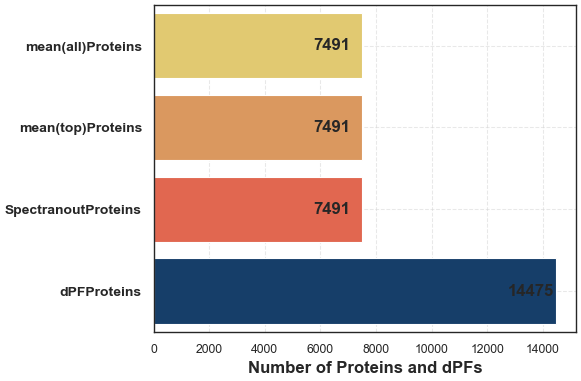

In [9]:
idComparison = {
    "SpectranoutProteins": 7491,
    "mean(top)Proteins": 7491 ,
    "mean(all)Proteins": 7491 ,
    "dPFProteins": 14475
}

plot_data = pd.DataFrame({
    "Data": list(dataTypes.keys()),
    "Count": list(idComparison.values())
})
fig, ax = plt.subplots(figsize=(6, 4))
sns.barplot(
    data=plot_data,
    x="Count",
    y="Data",
    palette=dataTypes,
    ax=ax,
    orient='h'
)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha="right", fontsize=10, fontweight="bold")
ax.set_xlabel("Number of Proteins and dPFs", fontsize=12, fontweight="bold")
ax.set_ylabel("", fontsize=12, fontweight="bold")
ax.grid("both", linestyle="--", linewidth=0.75, alpha=0.5, color="lightgrey")
# Add the count as text within the bars
for p in ax.patches:
    ax.annotate(
        f"{int(p.get_width())}",
        (p.get_width() - 2000, p.get_y() + p.get_height() / 2.),
        ha="left",
        va="center",
        xytext=(5, 0),
        textcoords="offset points",
        fontsize=12,
        fontweight="bold"

    )
plt.tight_layout()
# Save the figure
plots.save_figures(
    plt.gcf(),
    filename="ProteinsIdentified",
    filepath=figure_path,
    fileformat=figure_formats,
    dpi=figure_dpi,
    transparent=transparet_bg
)

## Combined PCA

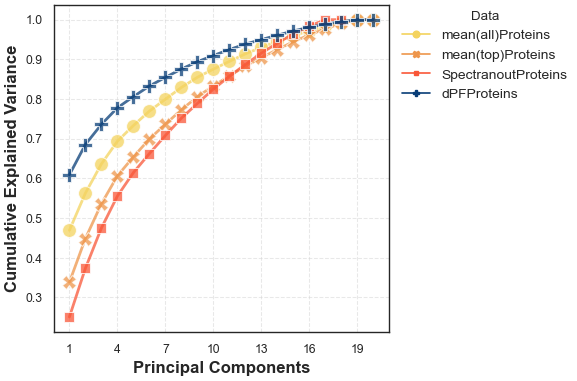

In [10]:
from sklearn.decomposition import PCA # PCA from scikit-learn
scaler = "minmax"
data_name = "centered_protein_data.feather"
proteinDatasets = {
    "mean(all)Proteins": feather.read_dataframe(f"{input_path}5_meanAllAnalysis/{data_name}"),
    "mean(top)Proteins": feather.read_dataframe(f"{input_path}6_meanTop3Analysis/{data_name}"),
    "SpectranoutProteins": feather.read_dataframe(f"{input_path}7_spectranoutAnalysis/{data_name}"),
    "dPFProteins": feather.read_dataframe(f"{input_path}8_proteoformAnalysis/{data_name}")
}

variance_data = []
for k, v in proteinDatasets.items():
    # Perform PCA on the centered data
    
    # Drop any missing values
    complete_data = v.dropna()
    # Scale the data
    scaled_data = utils.scale_the_data(
        complete_data,
        method=scaler,
        axis=1,
        is_log=False
    )
    # Run the PCA
    pca = PCA()
    pca_res = pca.fit_transform(scaled_data.T)
    pca_exp_var = pca.explained_variance_ratio_
    pca_exp_var_cum = np.cumsum(pca_exp_var)
    for i, cum_var in enumerate(pca_exp_var_cum):
        variance_data.append({
            "Data": k,
            "PC Component": i + 1,
            "Cumulative Variance": cum_var
        })

plot_data = pd.DataFrame(variance_data)

# Figure 1: Cumulative Explained Variance
fig, ax = plt.subplots(figsize=(6, 4))
sns.lineplot(
    ax=ax,
    data=plot_data,
    x="PC Component",
    y="Cumulative Variance",
    hue="Data",
    style="Data",
    palette=dataTypes,
    dashes=False,
    linewidth=2,
    markers=True, 
    markersize=10,
    alpha=0.75,    
)
# xticklabel style
ax.set_xticks(range(1, 21, 3))
# ax.set_xticklabels(ax.get_xticks(), rotation=0, ha="center", fontsize=10, fontweight="bold")
ax.set_xlabel("Principal Components", fontsize=12, fontweight="bold")
ax.set_ylabel("Cumulative Explained Variance", fontsize=12, fontweight="bold")
# ax.set_title("Cumulative Explained Variance", fontsize=14, fontweight="bold")
ax.grid("both", linestyle="--", linewidth=0.75, alpha=0.5, color="lightgrey")
ax.legend(bbox_to_anchor=(1.025, 1), loc=2, borderaxespad=0., fontsize=10, frameon=False, title="Data")
plt.tight_layout()
# Save the figure
plots.save_figures(
    plt.gcf(),
    filename="CumulativeExplainedVariance",
    filepath=figure_path,
    fileformat=figure_formats,
    dpi=figure_dpi,
    transparent=transparet_bg
)

##

In [11]:
test_colors = {
    "Equivalent": "#29335c",
    "UpRegulated": "#bc4749",
    "DownRegulated": "#386641",
    "Unexplained": "#ebd8d0",
    "Excluded": "#565d61"
}

def split_different(x):
    if x['Status'] == 'Different':
        if x['log2FC'] > 0:
            return 'UpRegulated'
        else:
            return 'DownRegulated'
    return x['Status']

testComparison = {}
for k, v in testResults.items():
    # Calculate Counts for each "Status" (Need to expand Different to Up/DownRegulated)
    # v['Regulation']  = v['log2FC'].apply(lambda x: 'Up' if x > 0 else 'Down')
    v['Status'] = v.apply(split_different, axis=1)
    testComparison[k] = v['Status'].value_counts().to_dict()
    # Get the Excluded Count from idComparison[k] - sum of all other counts
    testComparison[k]['Excluded'] = idComparison[k] - sum(testComparison[k].values())

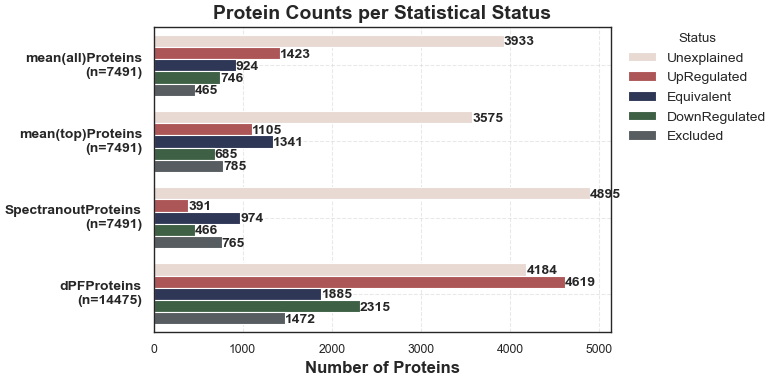

In [12]:
plot_data = pd.DataFrame(testComparison).reset_index().melt(
    id_vars="index",
    var_name="Protein Calculation",
    value_name="Count"
).rename(
    columns={"index": "Status"}
)
plot_data['Total'] = plot_data.groupby("Protein Calculation")['Count'].transform('sum')
plot_data['Percentage'] = plot_data['Count'] / plot_data['Total'] * 100
plot_data

# Create horizontal bar plot with Status as stacked bars and annotate the percentage for each stack
fig, ax = plt.subplots(figsize=(8, 4))
sns.barplot(
    data=plot_data,
    x="Count",
    y="Protein Calculation",
    hue="Status",
    palette=test_colors,
    orient="h",
    ax=ax
)
# Add the percentage as rotated within the bard centered from top
for p in ax.patches:
    ax.annotate(
        f"{p.get_width():.0f}",
        (p.get_width(), p.get_y() + p.get_height() / 2.),
        ha="left",
        va="center",
        xytext=(0, -1),
        textcoords="offset points",
        fontsize=10,
        fontweight="bold"
    )

# ax.set_xticklabels(ax.get_xticks(), rotation=0, ha="center", fontsize=10, fontweight="bold")
ax.set_ylabel("", fontsize=12, fontweight="bold")
ax.set_yticklabels(
    [
        f"{label.get_text()}\n(n={int(plot_data[plot_data['Protein Calculation'] == label.get_text()]['Total'].values[0])})" 
        for label in ax.get_yticklabels()
    ], 
    rotation=0, ha="right", va="center", 
    fontsize=10, fontweight="bold"
)
ax.set_xlabel("Number of Proteins", fontsize=12, fontweight="bold")
ax.set_title("Protein Counts per Statistical Status", fontsize=14, fontweight="bold")
ax.grid("both", linestyle="--", linewidth=0.75, alpha=0.5, color="lightgrey")
ax.legend(bbox_to_anchor=(1.025, 1), loc=2, borderaxespad=0., fontsize=10, frameon=False, title="Status")
plt.tight_layout()
# Save the figure
plots.save_figures(
    plt.gcf(),
    filename="ProteinCounts_StatisticalStatus",
    filepath=figure_path,
    fileformat=figure_formats,
    dpi=figure_dpi,
    transparent=transparet_bg
)

## Inspecting Pediatric Cancer Associated Proteins' Statistical Status Across Datasets

In [13]:
import PyComplexHeatmap as pch

In [14]:
cap_proteins = proteoform_info[proteoform_info['isCAP']].index.get_level_values("Protein").unique()
print(f"Number of CAP Proteins in data: {len(cap_proteins)}")
print(f"In Mean(All)Proteins: {testResults['mean(all)Proteins']['Protein'].isin(cap_proteins).sum()}")
print(f"In Mean(Top)Proteins: {testResults['mean(top)Proteins']['Protein'].isin(cap_proteins).sum()}")
print(f"In SpectranoutProteins: {testResults['SpectranoutProteins']['Protein'].isin(cap_proteins).sum()}")
print(f"In dPFProteins: {testResults['dPFProteins']['Proteoform'].str.split('_').str[0].isin(cap_proteins).sum()}")

Number of CAP Proteins in data: 184
In Mean(All)Proteins: 176
In Mean(Top)Proteins: 168
In SpectranoutProteins: 165
In dPFProteins: 346


## Inspecting the Enrichment Results

In [181]:
test_colors

{'Equivalent': '#29335c',
 'UpRegulated': '#bc4749',
 'DownRegulated': '#386641',
 'Unexplained': '#ebd8d0',
 'Excluded': '#565d61'}

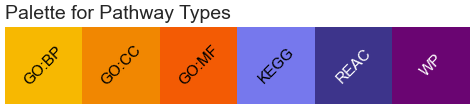

,query,source,native,name,significant,p_value,p_capped,-log10(p_value),-log10(p_capped),Enrichment,GeneRatio,parents,DataType
0,Downregulated in Tumor,GO:CC,GO:0005739,mitochondrion,True,0.0000,0.0000,25.9572,15.0000,2.3251,0.1310,"['GO:0005737', 'GO:0043231']",mean(all)
1,Downregulated in Tumor,GO:CC,GO:0005737,cytoplasm,True,0.0000,0.0000,25.9572,15.0000,1.2500,0.0704,"['GO:0005622', 'GO:0110165']",mean(all)
2,Downregulated in Tumor,REAC,REAC:R-HSA-1430728,Metabolism,True,0.0000,0.0000,22.8498,15.0000,2.1305,0.1201,['REAC:0000000'],mean(all)
3,Downregulated in Tumor,GO:BP,GO:0044281,small molecule metabolic process,True,0.0000,0.0000,21.1463,15.0000,2.2657,0.1277,['GO:0008152'],mean(all)
4,Upregulated in Tumor,GO:BP,GO:0007399,nervous system development,True,0.0000,0.0000,20.2403,15.0000,1.6784,0.1885,['GO:0048731'],mean(all)


In [182]:
enrichment_data = pd.concat(
    [
        enrichmentResults['mean(all)Proteins'].assign(DataType="mean(all)Proteins"),
        enrichmentResults['mean(top)Proteins'].assign(DataType="mean(top)Proteins"),
        enrichmentResults['SpectranoutProteins'].assign(DataType="SpectranoutProteins"),
        enrichmentResults['dPFProteins'].assign(DataType="dPFProteins")
    ],
    axis=0,
    ignore_index=True
)    

query_palette = {
    "Downregulated in Tumor": "#386641",
    "Equivalent": "#29335c",
    "Upregulated in Tumor": "#bc4749",
}
pathway_palette = {
    "GO:BP": "#f7b801",
    "GO:CC": "#f18701",
    "GO:MF": "#f35b04",
    "KEGG": "#7678ed",
    "REAC": "#3d348b",
    "WP": "#6a0572"
}
dataType_styles = {
    "mean(all)": "o",
    "mean(top3)": "s",
    "Spectronaut": "D",
    "dPF": "^"
}
enrichment_data['query'] = enrichment_data['query'].map(
    {'Tumor-Down': "Downregulated in Tumor", 'Tumor-Up': "Upregulated in Tumor", 'Equivalent': "Equivalent"}
)
enrichment_data['DataType'] = enrichment_data['DataType'].map(
    {'mean(all)Proteins': "mean(all)", 'mean(top)Proteins': "mean(top3)", 'SpectranoutProteins': "Spectronaut", 'dPFProteins': "dPF"}
)

# Remove source == 'WP'
enrichment_data = enrichment_data[enrichment_data['source'] != 'WP']

plots.color_palette(
    pathway_palette,
    name="Pathway Types",
    save=False
)

enrichment_data.head()

### Creating 

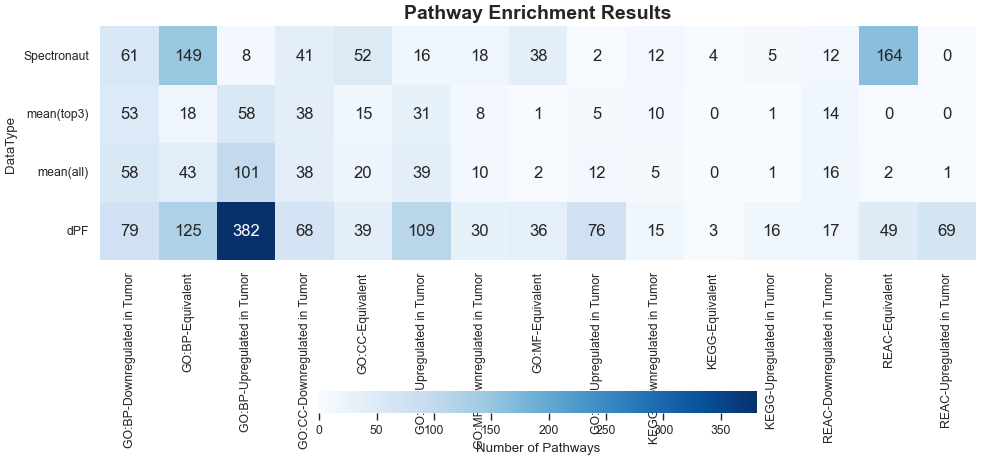

In [183]:
plot_data = enrichment_data.groupby(['source', 'query', 'DataType']).size().unstack().fillna(0)
plot_data = plot_data[['Spectronaut', 'mean(top3)', 'mean(all)', 'dPF']]
fig, ax = plt.subplots(figsize=(10, 9))
sns.heatmap(
    plot_data.T,
    cmap="Blues",
    annot=True,
    square=True,
    fmt=".0f",
    ax=ax,
    cbar_kws={"label": "Number of Pathways", "orientation": "horizontal", "shrink": 0.5},
    annot_kws={"fontsize": 12, },
)
ax.set_xlabel("", fontsize=12, fontweight="bold")
# ax.set_ylabel("Protein Regulation", fontsize=12, fontweight="bold")
ax.set_title("Pathway Enrichment Results", fontsize=14, fontweight="bold")
plt.tight_layout()

# Save the figure
plots.save_figures(
    plt.gcf(),
    filename="PathwayEnrichmentResults",
    filepath=figure_path,
    fileformat=figure_formats,
    dpi=figure_dpi,
    transparent=transparet_bg
)

### Summarizing the KEGG Pathway Enrichment Results

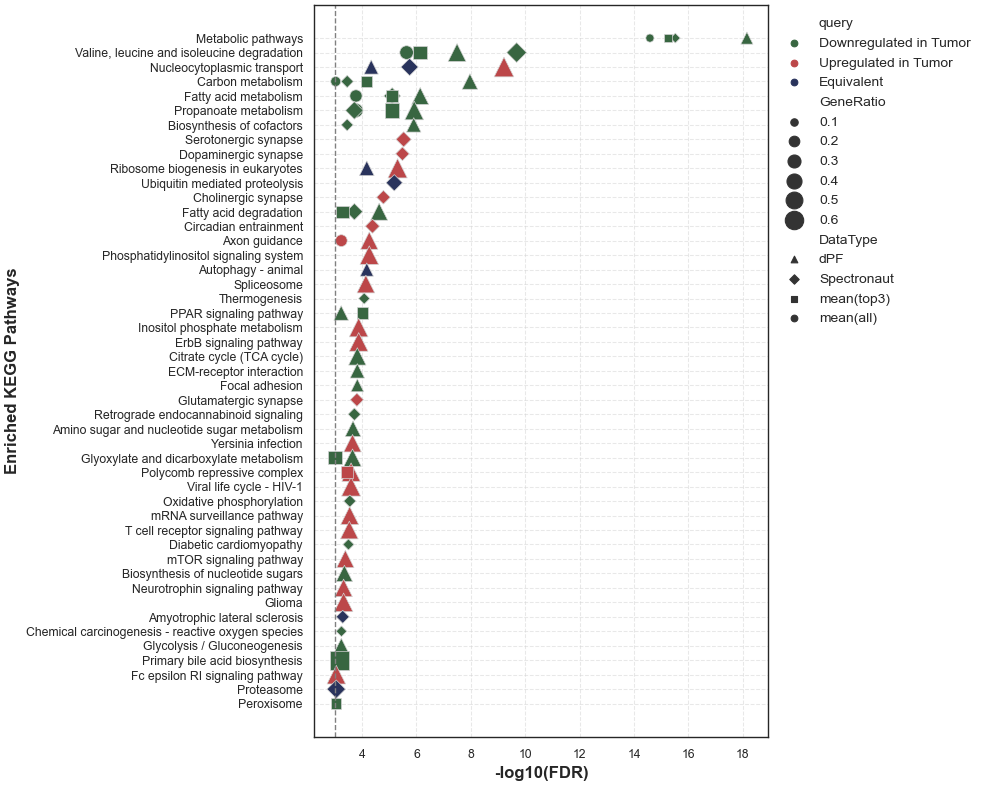

In [184]:
cur_source = "KEGG"
plot_data = enrichment_data[
    (enrichment_data["source"] == cur_source) & 
    (enrichment_data["native"]!=f"{cur_source}:00000")
].sort_values('p_value').copy()
n_unique = plot_data["native"].nunique()

# Initialize the figure
fig, ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(10, 1 + n_unique * 0.15),
)

sns.scatterplot(
    ax=ax,
    data=plot_data,
    y="name",
    x="-log10(p_value)",
    hue="query",
    style="DataType",
    size="GeneRatio",
    edgecolor="lightgray",
    palette=query_palette,
    markers=dataType_styles,
    linewidth=.5,
    sizes=(25, 200),
    legend='brief',
)
# Add line at p-value cutoff
ax.axvline( -np.log10(0.001), color="gray", linestyle="--", linewidth=1 )

# Add Styling to the plot
ax.set_xlabel("-log10(FDR)", fontsize=12, fontweight="bold")
ax.set_ylabel(f"Enriched {cur_source} Pathways", fontsize=12, fontweight="bold")
# Add grid
ax.grid("both", linestyle="--", linewidth=0.75, alpha=0.5, color="lightgrey")
ax.legend(
    frameon=False,
    fontsize=10,
    title_fontsize=14,
    loc="upper left",
    bbox_to_anchor=(1, 1),
    # title="Enrichment Query",
)
plt.tight_layout()
# Save the figure
plots.save_figures(
    plt.gcf(),
    filename=f"Comparing_Enrichment_{cur_source}",
    filepath=figure_path,
    fileformat=figure_formats,
    dpi=figure_dpi,
    transparent=transparet_bg
)

In [185]:
# cur_source = "REAC"
# plot_data = enrichment_data[
#     (enrichment_data["source"] == cur_source) & 
#     (enrichment_data["native"]!=f"{cur_source}:00000")
# ].sort_values('p_value').copy()
# n_unique = plot_data["native"].nunique()

# # Initialize the figure
# fig, ax = plt.subplots(
#     nrows=1,
#     ncols=1,
#     figsize=(8, 1 + n_unique * 0.25),
# )

# sns.scatterplot(
#     ax=ax,
#     data=plot_data,
#     y="name",
#     x="-log10(p_value)",
#     hue="query",
#     style="DataType",
#     size="GeneRatio",
#     edgecolor="lightgray",
#     palette=query_palette,
#     markers=dataType_styles,
#     linewidth=.5,
#     sizes=(25, 200),
#     legend='brief',
# )
# # Add line at p-value cutoff
# ax.axvline( -np.log10(0.001), color="gray", linestyle="--", linewidth=1 )

# # Add Styling to the plot
# ax.set_xlabel("-log10(FDR)", fontsize=12, fontweight="bold")
# ax.set_ylabel(f"Enriched {cur_source} Pathways", fontsize=12, fontweight="bold")
# # Add grid
# ax.grid("both", linestyle="--", linewidth=0.75, alpha=0.5, color="lightgrey")
# ax.legend(
#     frameon=False,
#     fontsize=10,
#     title_fontsize=14,
#     loc="upper left",
#     bbox_to_anchor=(1, 1),
#     # title="Enrichment Query",
# )
# plt.tight_layout()
# # Save the figure
# plots.save_figures(
#     plt.gcf(),
#     filename=f"Comparing_Enrichment_{cur_source}",
#     filepath=figure_path,
#     fileformat=figure_formats,
#     dpi=figure_dpi,
#     transparent=transparet_bg
# )

### Summarizing the REACTOME Pathways

In [186]:
reactome_pathways = pd.read_csv(
    f"./data/input/ReactomePathways.txt", 
    sep="\t", 
    header=None, 
    engine='pyarrow'
)
print()
reactome_pathways.columns = ["PathwayID", "PathwayName", "Organism"]
print("Data Shape:", reactome_pathways.shape)
utils.print_series(
    reactome_pathways["Organism"].value_counts(),
    header="Number of pathways per organism"
)
print()
# Subset for only human pathways
reactome_pathways = reactome_pathways[
    reactome_pathways["Organism"] == "Homo sapiens"
].reset_index(drop=True)
print("Data Shape after:", reactome_pathways.shape)
reactome_pathways.head()


Data Shape: (22084, 3)
Number of pathways per organism
 Homo sapiens -> 2673
 Mus musculus -> 1737
 Gallus gallus -> 1736
 Rattus norvegicus -> 1724
 Bos taurus -> 1718
 Sus scrofa -> 1709
 Canis familiaris -> 1690
 Drosophila melanogaster -> 1511
 Xenopus tropicalis -> 1502
 Danio rerio -> 1353
 Caenorhabditis elegans -> 1350
 Dictyostelium discoideum -> 1024
 Schizosaccharomyces pombe -> 864
 Saccharomyces cerevisiae -> 850
 Plasmodium falciparum -> 630
 Mycobacterium tuberculosis -> 13

Data Shape after: (2673, 3)


,PathwayID,PathwayName,Organism
0,R-HSA-164843,2-LTR circle formation,Homo sapiens
1,R-HSA-73843,5-Phosphoribose 1-diphosphate biosynthesis,Homo sapiens
2,R-HSA-1971475,A tetrasaccharide linker sequence is required ...,Homo sapiens
3,R-HSA-5619084,ABC transporter disorders,Homo sapiens
4,R-HSA-1369062,ABC transporters in lipid homeostasis,Homo sapiens


In [187]:
paired_hierarchy = pd.read_csv(
    f"./data/input/ReactomePathwaysRelation.txt",
    sep="\t", 
    header=None, 
    engine='pyarrow'
)
paired_hierarchy.columns = ["Parent", "Child"]

# Subset only Human pathways in paired_hierarcy
paired_hierarchy = paired_hierarchy[
    (paired_hierarchy["Parent"].isin(reactome_pathways["PathwayID"])) | 
    (paired_hierarchy["Child"].isin(reactome_pathways["PathwayID"]))
].reset_index(drop=True)

# Create Parent: All Children Dictionary
term_dict = paired_hierarchy.groupby('Parent')['Child'].apply(list).to_dict()

print("Data Shape:", paired_hierarchy.shape)
paired_hierarchy.head()

Data Shape: (2665, 2)


,Parent,Child
0,R-HSA-109581,R-HSA-109606
1,R-HSA-109581,R-HSA-169911
2,R-HSA-109581,R-HSA-5357769
3,R-HSA-109581,R-HSA-75153
4,R-HSA-109582,R-HSA-140877


In [188]:
reactome_pathways = pd.read_csv("./data/input/ReactomeDetailed.txt", sep="\t", engine='pyarrow')
reactome_pathways["Parent"] = reactome_pathways["Parent"].replace(np.nan, "Top Level")
term_dict = reactome_pathways.set_index("PathwayID")["Parent"].to_dict()

def recursive_find(term, term_dict):
    # If the term is not in the dictionary, it is a "Top Level" parent
    if term not in term_dict:
        return term
    # If the parent of the term is a "Top Level" parent, return the term
    elif term_dict[term] not in term_dict:
        return term
    # Otherwise, continue with the parent of the term
    else:
        return recursive_find(term_dict[term], term_dict)
    

term_name_dict = reactome_pathways.set_index("PathwayID")["PathwayName"].to_dict()
reactome_pathways

,PathwayID,PathwayName,Parent,NumChildren
0,R-HSA-164843,2-LTR circle formation,R-HSA-162592,0
1,R-HSA-73843,5-Phosphoribose 1-diphosphate biosynthesis,R-HSA-71336,0
2,R-HSA-1971475,A tetrasaccharide linker sequence is required ...,R-HSA-1793185,0
3,R-HSA-5619084,ABC transporter disorders,R-HSA-5619115,15
4,R-HSA-1369062,ABC transporters in lipid homeostasis,R-HSA-382556,0
...,...,...,...,...
2668,R-HSA-9703009,tamatinib-resistant FLT3 mutants,R-HSA-9702506,0
2669,R-HSA-9702636,tandutinib-resistant FLT3 mutants,R-HSA-9702506,0
2670,R-HSA-199992,trans-Golgi Network Vesicle Budding,R-HSA-199991,2
2671,R-HSA-192814,vRNA Synthesis,R-HSA-168273,0


In [214]:
subset_data = enrichment_data[
    (enrichment_data["source"] == "REAC") & 
    (enrichment_data["native"] != "REAC:00000")
].copy()

signf_react_data = subset_data.sort_values(
    ["-log10(p_capped)"], 
    ascending=False
).copy()

signf_react_data = signf_react_data[[
    "query",
    "source", 
    "name",
    "native", 
    "GeneRatio",
    "Enrichment",
    "p_value",
    "-log10(p_value)",
    "-log10(p_capped)",
    'DataType'
]]

signf_react_data["native"] = signf_react_data["native"].str.replace("REAC:", "").str.strip()

# Identify the main parent pathway for given pathways
signf_react_data["Group"] = signf_react_data["native"].apply(
    lambda x: recursive_find(x, term_dict)
)
signf_react_data["Group Label"] = signf_react_data["Group"].map(
    reactome_pathways.set_index("PathwayID")["PathwayName"]
)

plot_data = signf_react_data.groupby(["query", "DataType", "Group Label"]).size().unstack().fillna(0).astype(int)

parent_counts = reactome_pathways.loc[
    reactome_pathways["Parent"] == "Top Level",
    ["PathwayName", "NumChildren"]
].set_index("PathwayName").loc[plot_data.columns]

# Each column is a group divide each column by the number of children
plot_data_pct = plot_data.divide(parent_counts["NumChildren"], axis=1) * 100

plot_data_pct.columns = plot_data_pct.columns.map(
    # Add the count n= to the column name
    lambda x: x + " (n="+str(parent_counts["NumChildren"].to_dict()[x])+")"
)

print("Previewing the top 25 entries in queried main pathway sizes:")
signf_react_data.groupby(["query", "DataType", "Group Label"]).size().sort_values(ascending=False).head(25)

Previewing the top 25 entries in queried main pathway sizes:


query                   DataType     Group Label                    
Equivalent              Spectronaut  Cell Cycle                         36
                                     Disease                            26
                                     Metabolism of proteins             21
                                     Signal Transduction                18
                                     Metabolism of RNA                  18
                        dPF          Disease                            16
Upregulated in Tumor    dPF          Metabolism of RNA                  16
                                     Signal Transduction                12
Equivalent              dPF          Metabolism of RNA                  12
Upregulated in Tumor    dPF          Disease                            11
Downregulated in Tumor  mean(all)    Metabolism                         11
Equivalent              Spectronaut  Immune System                      11
Downregulated in Tumor  Spectro

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Plotting legends..
Estimated legend width: 7.5 mm


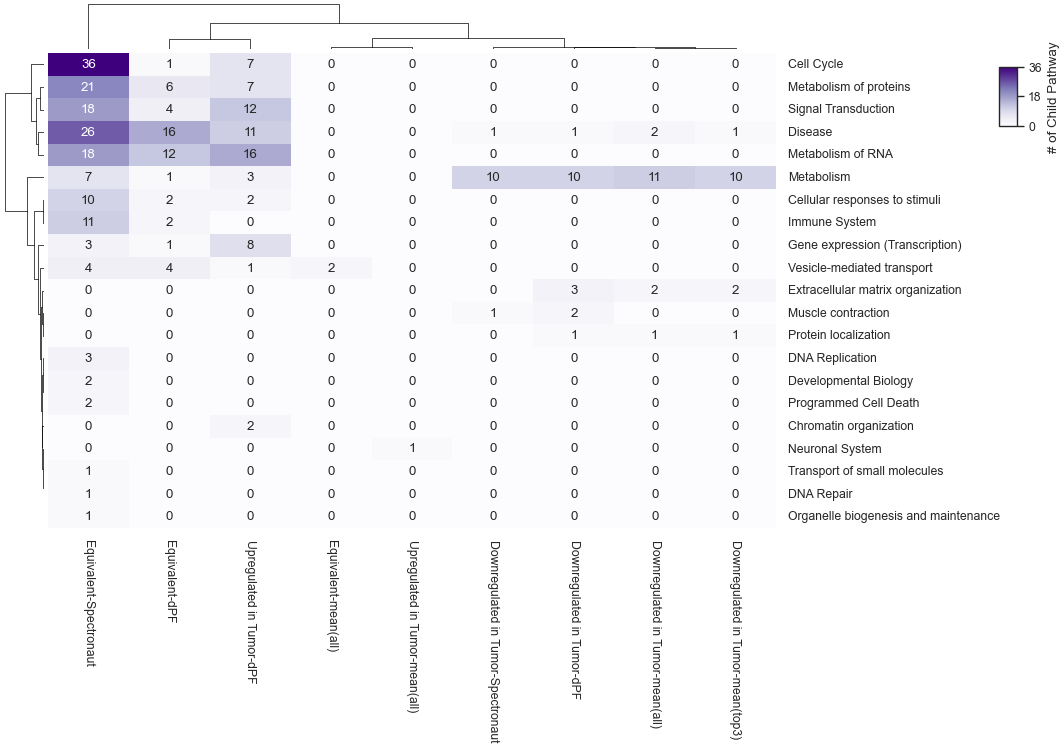

In [215]:
# Create the Clustermap (PyComplexHeatmap)
fig, ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(10, 6),
)

res = pch.ClusterMapPlotter(
    data = plot_data.T,
    cmap = "Purples",
    # Row 
    row_cluster=True,
    row_cluster_method="ward",
    row_cluster_metric="euclidean",
    show_rownames=True,
    # row_split=2,
    # row_split_gap=1,
    row_dendrogram=True,

    # Column
    col_cluster=True,
    col_cluster_method="ward",
    col_cluster_metric="euclidean",
    show_colnames=True,
    # col_split=2,
    # col_split_gap=1,
    col_dendrogram=True,

    # Labels
    label="# of Child Pathway",
    # Annotations
    annot=True,
)


# Save the figure
plots.save_figures(
    plt.gcf(),
    filename="ReactomePathwayClustermap",
    filepath=figure_path,
    fileformat=figure_formats,
    dpi=figure_dpi,
    transparent=transparet_bg,
)

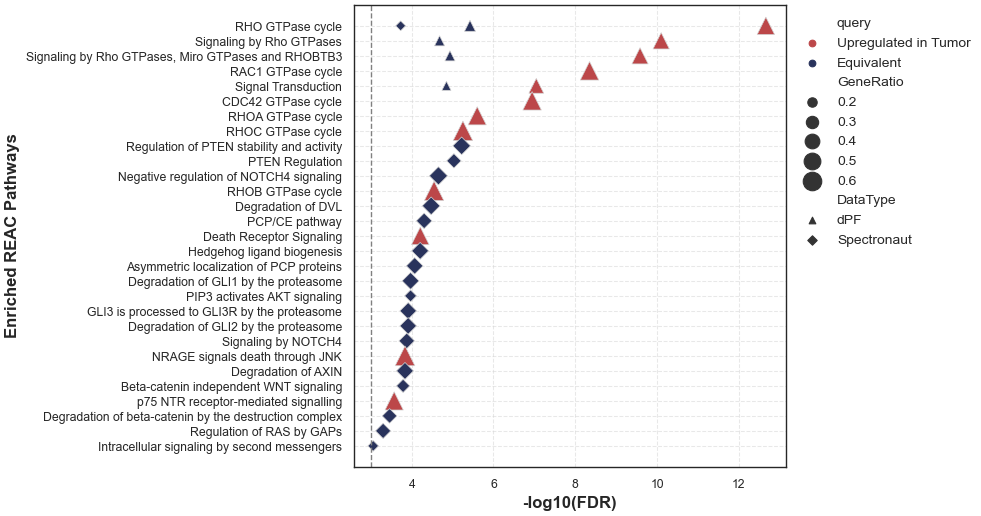

In [191]:
cur_source = "REAC"
reactomeGroup = 'Signal Transduction'
plot_data = signf_react_data[
    signf_react_data['Group Label'] == reactomeGroup
].sort_values('p_value').copy()

n_unique = plot_data["native"].nunique()

# Initialize the figure
fig, ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(10, 1 + n_unique * 0.15),
)

sns.scatterplot(
    ax=ax,
    data=plot_data,
    y="name",
    x="-log10(p_value)",
    hue="query",
    style="DataType",
    size="GeneRatio",
    edgecolor="lightgray",
    palette=query_palette,
    markers=dataType_styles,
    linewidth=.5,
    sizes=(25, 200),
    legend='brief',
)
# Add line at p-value cutoff
ax.axvline( -np.log10(0.001), color="gray", linestyle="--", linewidth=1 )

# Add Styling to the plot
ax.set_xlabel("-log10(FDR)", fontsize=12, fontweight="bold")
ax.set_ylabel(f"Enriched {cur_source} Pathways", fontsize=12, fontweight="bold")
# Add grid
ax.grid("both", linestyle="--", linewidth=0.75, alpha=0.5, color="lightgrey")
ax.legend(
    frameon=False,
    fontsize=10,
    title_fontsize=14,
    loc="upper left",
    bbox_to_anchor=(1, 1),
    # title="Enrichment Query",
)
plt.tight_layout()
# Save the figure
plots.save_figures(
    plt.gcf(),
    filename=f"Comparing_Enrichment_{cur_source}_{reactomeGroup}",
    filepath=figure_path,
    fileformat=figure_formats,
    dpi=figure_dpi,
    transparent=transparet_bg
)

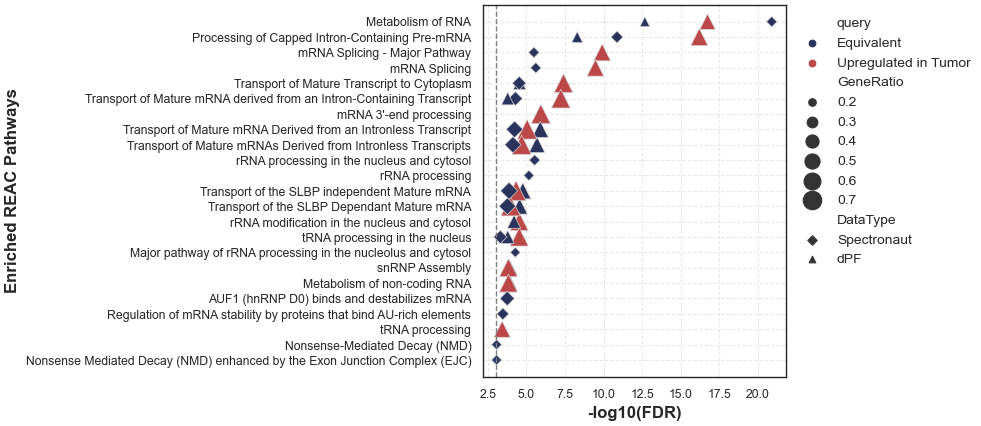

In [192]:
cur_source = "REAC"
reactomeGroup = 'Metabolism of RNA'
plot_data = signf_react_data[
    signf_react_data['Group Label'] == reactomeGroup
].sort_values('p_value').copy()

n_unique = plot_data["native"].nunique()

# Initialize the figure
fig, ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(10, 1 + n_unique * 0.15),
)

sns.scatterplot(
    ax=ax,
    data=plot_data,
    y="name",
    x="-log10(p_value)",
    hue="query",
    style="DataType",
    size="GeneRatio",
    edgecolor="lightgray",
    palette=query_palette,
    markers=dataType_styles,
    linewidth=.5,
    sizes=(25, 200),
    legend='brief',
)
# Add line at p-value cutoff
ax.axvline( -np.log10(0.001), color="gray", linestyle="--", linewidth=1 )

# Add Styling to the plot
ax.set_xlabel("-log10(FDR)", fontsize=12, fontweight="bold")
ax.set_ylabel(f"Enriched {cur_source} Pathways", fontsize=12, fontweight="bold")
# Add grid
ax.grid("both", linestyle="--", linewidth=0.75, alpha=0.5, color="lightgrey")
ax.legend(
    frameon=False,
    fontsize=10,
    title_fontsize=14,
    loc="upper left",
    bbox_to_anchor=(1, 1),
    # title="Enrichment Query",
)
plt.tight_layout()
# Save the figure
plots.save_figures(
    plt.gcf(),
    filename=f"Comparing_Enrichment_{cur_source}_{reactomeGroup}",
    filepath=figure_path,
    fileformat=figure_formats,
    dpi=figure_dpi,
    transparent=transparet_bg
)

# GTPase Cycle

In [217]:
# Uniprot maps
uniprot2reactome = pd.read_csv("./data/input/UniProt2Reactome_All_Levels.txt", sep="\t", engine='pyarrow', header=None)
# R-HSA-9012999
uniprot2reactome = uniprot2reactome[uniprot2reactome[5] == 'Homo sapiens']
uniprot2reactome = uniprot2reactome[[0, 1, 3]]
uniprot2reactome.columns = ['Protein', 'PathwayID', 'PathwayName']
uniprot2reactome = uniprot2reactome.set_index('PathwayID')
uniprot2reactome


,Protein,PathwayName
PathwayID,,
R-HSA-109582,A0A075B6P5,Hemostasis
R-HSA-1280218,A0A075B6P5,Adaptive Immune System
R-HSA-1280218,A0A075B6P5,Adaptive Immune System
R-HSA-1643685,A0A075B6P5,Disease
R-HSA-1643685,A0A075B6P5,Disease
...,...,...
R-HSA-166662,Q9Y6Z7,Lectin pathway of complement activation
R-HSA-166663,Q9Y6Z7,Initial triggering of complement
R-HSA-166786,Q9Y6Z7,Creation of C4 and C2 activators


In [219]:
def list_children(term, term_dict, term_name_dict):
    """Create a neat new line and tab listed print of the children of a term"""
    # Base case: The term is not in the dictionary (it has no children)
    if term not in term_dict:
        return ""

    # Recursive case: The term is in the dictionary
    else:
        children = term_dict[term]
        children_names = [term_name_dict[child] for child in children]
        children_names.sort()
        children_names = "\n".join(children_names)
        children_names = "\n\t" + children_names
        for child in children:
            children_names += list_children(child, term_dict, term_name_dict)
        return children_names
    
term = "R-HSA-9012999" 
print(term ,"-" , term_name_dict[term])
# print(list_children(term, term_dict, term_name_dict))

R-HSA-9012999 - RHO GTPase cycle


In [195]:
# Create two venn diagrams using two pandas series containing status
status = ['Unexplained', 'DownRegulated', 'Equivalent', 'UpRegulated', 'NotInData']
childPathways = paired_hierarchy.loc[paired_hierarchy['Parent'] == 'R-HSA-9012999', 'Child'].to_list()

# Initialize a list to collect the status counts
status_list = []
pathway_counts = {}
# Loop over the childPathways
for cur_pathway in childPathways:
    cur_pathway_name = term_name_dict[cur_pathway]
    cur_pathway_proteins = uniprot2reactome.loc[cur_pathway, 'Protein'].to_list()
    pathway_counts[cur_pathway_name] = len(cur_pathway_proteins)
    print(f"{cur_pathway} - {cur_pathway_name} - {len(cur_pathway_proteins)}")
    
    for method in dataTypes.keys():
        tmp = testResults[method].copy()
        cur_proteins = tmp['Protein'].unique()
        cur_proteins = list(set(cur_proteins).intersection(cur_pathway_proteins))
        mis_proteins = list(set(cur_pathway_proteins) - set(cur_proteins))
        print(f" - {method}: {len(cur_proteins)}")
        
        status_counts = tmp[
            (tmp['Protein'].isin(cur_proteins)) & 
            ((tmp['Proteoform'].str.contains('_0')))
        ]['Status'].value_counts()
        status_counts = status_counts.reindex(status, fill_value=0)
        status_counts['NotInData'] = len(mis_proteins)
        
        # Collect the status counts into the list
        for stat in status:
            status_list.append({
                'Pathway': cur_pathway_name,
                'Method': method,
                'Status': stat,
                'Count': status_counts[stat]
            })
        
        if method == 'dPFProteins':
            # A dPF version
            onlydPFs = tmp[
                (tmp['Protein'].isin(cur_proteins)) & 
                (~(tmp['Proteoform'].str.contains('_0')))
            ]['Status'].value_counts()
            onlydPFs = onlydPFs.reindex(status, fill_value=0)
            onlydPFs['NotInData'] = len(mis_proteins)
            
            # Collect the dPF status counts into the list
            for stat in status:
                status_list.append({
                    'Pathway': cur_pathway_name,
                    'Method': 'onlydPFs',
                    'Status': stat,
                    'Count': onlydPFs[stat]
                })
    
# Convert the list to a DataFrame
status_df = pd.DataFrame(status_list)

R-HSA-8980692 - RHOA GTPase cycle - 150
 - mean(all)Proteins: 105
 - mean(top)Proteins: 102
 - SpectranoutProteins: 105
 - dPFProteins: 110
R-HSA-9013026 - RHOB GTPase cycle - 71
 - mean(all)Proteins: 52
 - mean(top)Proteins: 50
 - SpectranoutProteins: 54
 - dPFProteins: 57
R-HSA-9013106 - RHOC GTPase cycle - 75
 - mean(all)Proteins: 61
 - mean(top)Proteins: 59
 - SpectranoutProteins: 62
 - dPFProteins: 65
R-HSA-9013148 - CDC42 GTPase cycle - 155
 - mean(all)Proteins: 107
 - mean(top)Proteins: 103
 - SpectranoutProteins: 108
 - dPFProteins: 110
R-HSA-9013149 - RAC1 GTPase cycle - 185
 - mean(all)Proteins: 136
 - mean(top)Proteins: 133
 - SpectranoutProteins: 134
 - dPFProteins: 139
R-HSA-9013404 - RAC2 GTPase cycle - 88
 - mean(all)Proteins: 72
 - mean(top)Proteins: 72
 - SpectranoutProteins: 71
 - dPFProteins: 74
R-HSA-9013405 - RHOD GTPase cycle - 53
 - mean(all)Proteins: 36
 - mean(top)Proteins: 36
 - SpectranoutProteins: 37
 - dPFProteins: 37
R-HSA-9013406 - RHOQ GTPase cycle - 59


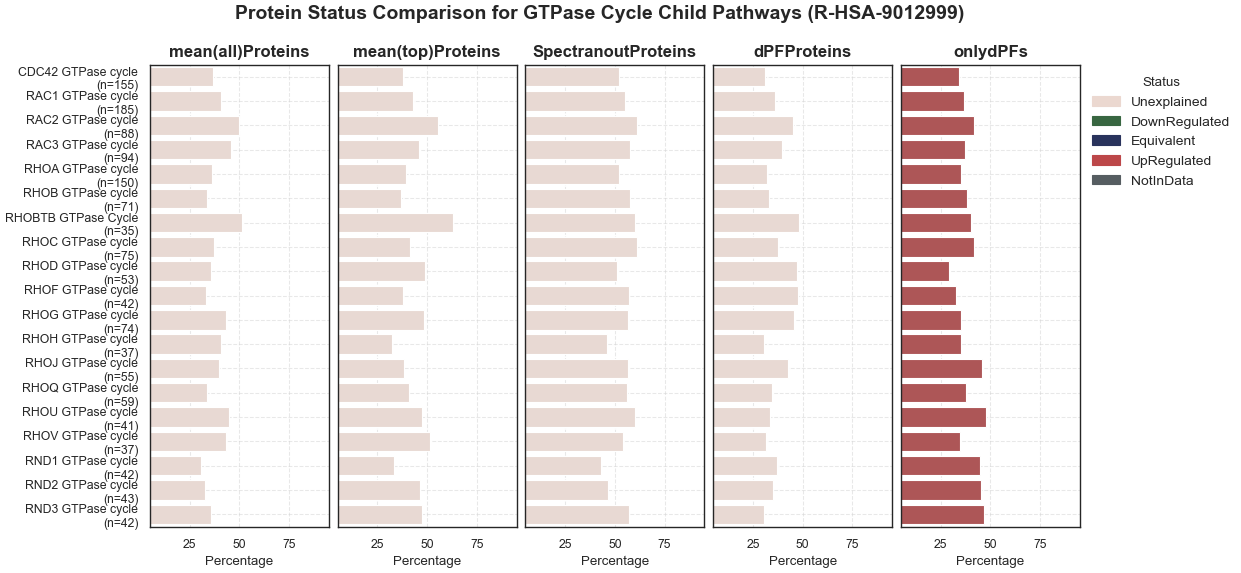

In [197]:
# Create a color palette for the statuses
status_colors = {
    'Unexplained': '#ebd8d0',
    'DownRegulated': '#386641',
    'Equivalent': '#29335c',
    'UpRegulated': '#bc4749',
    'NotInData': '#565d61'
}
# Pivot the DataFrame to get the data in the right format for plotting
pivot_df = status_df.pivot_table(
    index=['Pathway', 'Method'],
    columns='Status',
    values='Count',
    fill_value=0
)
pivot_df = pivot_df[list(status_colors.keys())].div(
    pivot_df.sum(axis=1), axis=0
) * 100

# Find the column per row the value is highest
maxStatus = pivot_df.idxmax(axis=1)
maxValue = pivot_df.max(axis=1)


plot_data = pd.concat([maxStatus, maxValue], axis=1).reset_index()  
plot_data.columns = ['Pathway', 'Method', 'Status', 'Percentage']
# Plot bars using matplotlib, color based on the maxStatus
fig, ax = plt.subplots(figsize=(12, 6), nrows=1, ncols=5, sharey=True, sharex=True, gridspec_kw={'wspace': 0.05})
for i, cur_method in enumerate([
    'mean(all)Proteins', 'mean(top)Proteins', 'SpectranoutProteins', 'dPFProteins', 'onlydPFs'
]):
    cur_data = plot_data[plot_data['Method'] == cur_method]
    sns.barplot(
        data=cur_data,
        x='Percentage',
        y='Pathway',
        hue='Status',
        palette=status_colors,
        ax=ax[i]
    )
    # Remove the legend
    ax[i].get_legend().remove()
    ax[i].set_title(f"{cur_method}", fontsize=12, fontweight="bold")
    ax[i].set_xlabel("Percentage")
    ax[i].set_ylabel("")    
    ax[i].grid("both", linestyle="--", linewidth=0.75, alpha=0.5, color="lightgrey")
    ax[i].set_xlim(5, 95)
    # ax[i].set_xticks([0, 25, 50, 75, 100])

# Add the legend for the last plot from the status_colors
handles = [plt.Rectangle((0,0),1,1, color=status_colors[stat]) for stat in status_colors.keys()]
labels = list(status_colors.keys())
ax[4].legend(
    handles, labels,
    title="Status",
    loc="upper left",
    bbox_to_anchor=(1, 1),
    frameon=False,
    fontsize=10
)

# Modify the y-ticklabels by Removing GTPase Cycle from the pathway names and add (n={count})<- # pathway_counts
new_labels = [
    f"{x.get_text().replace('GTPase cycle - ', '')}\n(n={pathway_counts.get(x.get_text().replace('GTPase cycle - ', ''), 0)})"
    for x in ax[0].get_yticklabels()
]
for i in range(5):
    ax[i].set_yticklabels(new_labels)


# Add title and tight layout
fig.suptitle("Protein Status Comparison for GTPase Cycle Child Pathways (R-HSA-9012999)", fontsize=14, fontweight="bold")


plt.tight_layout()
# Save the figure
plots.save_figures(
    plt.gcf(),
    filename=f"PathwayStatus_Comparison_GTPaseCycles",
    filepath=figure_path,
    fileformat=figure_formats,
    dpi=figure_dpi,
    transparent=transparet_bg
)


 - mean(all)Proteins: 324
 - mean(top)Proteins: 313
 - SpectranoutProteins: 324
 - dPFProteins: 334


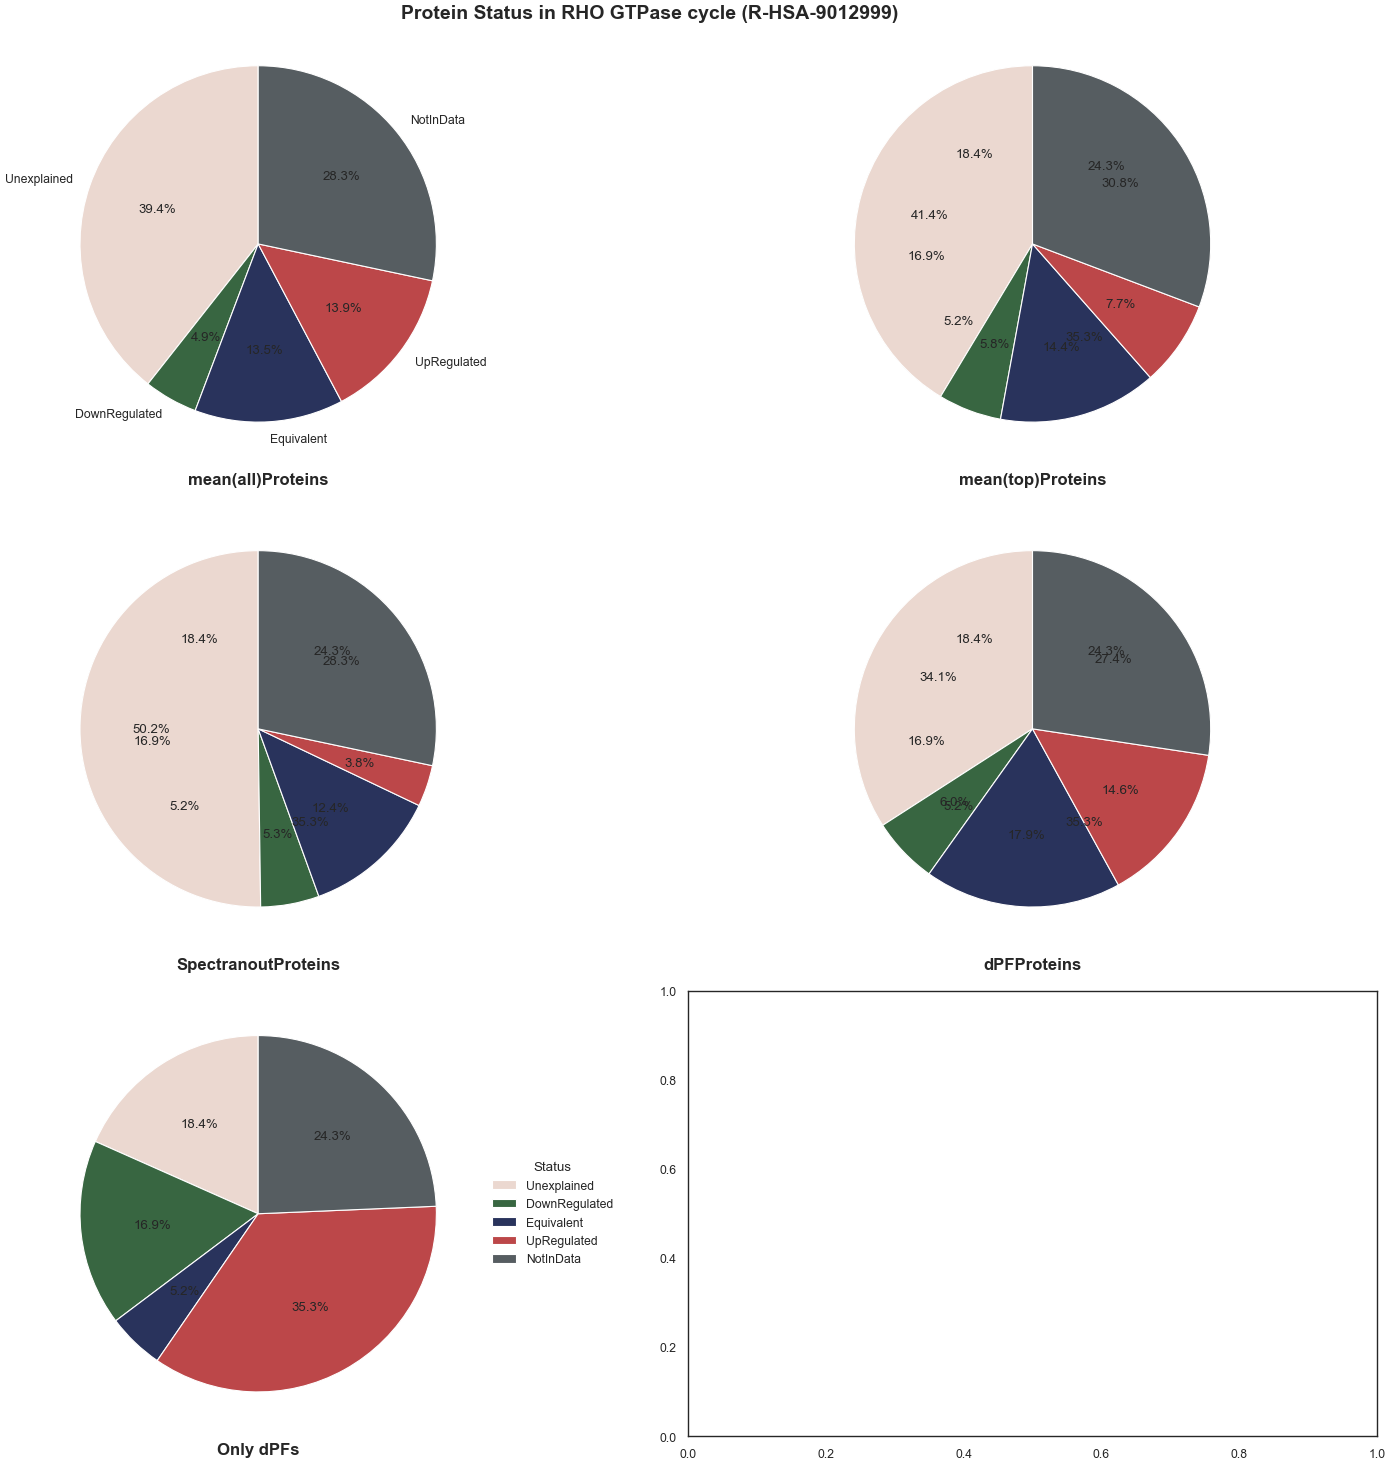

In [198]:
cur_pathway = 'R-HSA-9012999'
cur_pathway_name = term_name_dict[cur_pathway]
cur_pathway_proteins = uniprot2reactome.loc[cur_pathway, 'Protein'].to_list()

status = ['Unexplained', 'DownRegulated', 'Equivalent', 'UpRegulated', 'NotInData']

colors = [
    status_colors['Unexplained'],
    status_colors['DownRegulated'],
    status_colors['Equivalent'],
    status_colors['UpRegulated'],
    status_colors['NotInData']
]

# Initialize a list to collect the status counts
status_list = []

# Loop over the methods
for method in dataTypes.keys():
    tmp = testResults[method].copy()
    cur_proteins = tmp['Protein'].unique()
    cur_proteins = list(set(cur_proteins).intersection(cur_pathway_proteins))
    mis_proteins = list(set(cur_pathway_proteins) - set(cur_proteins))
    print(f" - {method}: {len(cur_proteins)}")
    
    status_counts = tmp[
        (tmp['Protein'].isin(cur_proteins)) & 
        ((tmp['Proteoform'].str.contains('_0')))
    ]['Status'].value_counts()
    status_counts = status_counts.reindex(status, fill_value=0)
    status_counts['NotInData'] = len(mis_proteins)
    
    # Collect the status counts into the list
    for stat in status:
        status_list.append({
            'Method': method,
            'Status': stat,
            'Count': status_counts[stat]
        })
    
    if method == 'dPFProteins':
        # A dPF version
        onlydPFs = tmp[
            (tmp['Protein'].isin(cur_proteins)) & 
            (~(tmp['Proteoform'].str.contains('_0')))
        ]['Status'].value_counts()
        onlydPFs = onlydPFs.reindex(status, fill_value=0)
        onlydPFs['NotInData'] = len(mis_proteins)
        
        # Collect the dPF status counts into the list
        for stat in status:
            status_list.append({
                'Method': 'onlydPFs',
                'Status': stat,
                'Count': onlydPFs[stat]
            })

# Convert the list to a DataFrame
status_df = pd.DataFrame(status_list)

# Plot venn diagrams for each method
fig, ax = plt.subplots(3, 2, figsize=(15, 15))
ax = ax.flatten()

for i, method in enumerate(dataTypes.keys()):
    withCanonical = status_df[(status_df['Method'] == method)].set_index('Status')['Count']
    onlydPFs = status_df[(status_df['Method'] == 'onlydPFs')].set_index('Status')['Count']
    
    # Ensure they all have same index
    withCanonical = withCanonical.reindex(status, fill_value=0)
    onlydPFs = onlydPFs.reindex(status, fill_value=0)
    
    # First pie chart with labels
    if i == 0:
        ax[i].pie(withCanonical, labels=withCanonical.index, autopct='%1.1f%%', startangle=90, colors=colors)
    else:
        ax[i].pie(withCanonical, labels=None, autopct='%1.1f%%', startangle=90, colors=colors)
    ax[i].set_xlabel(f"{method}", fontsize=12, fontweight="bold")
    
    # Second pie chart without labels
    wedges, texts, autotexts = ax[i+1].pie(onlydPFs, labels=None, autopct='%1.1f%%', startangle=90, colors=colors)
    ax[i+1].set_xlabel(f"Only dPFs", fontsize=12, fontweight="bold")
    
    # Create a single legend for the second pie chart
    if i == len(dataTypes.keys()) - 1:
        ax[i+1].legend(wedges, onlydPFs.index, title="Status", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1), frameon=False)

fig.suptitle(f"Protein Status in {cur_pathway_name} ({cur_pathway})", fontsize=14, fontweight="bold")
plt.tight_layout()

# Save the figure
plots.save_figures(
    plt.gcf(),
    filename=f"ProteinStatusComparisons_{cur_pathway}",
    filepath=figure_path,
    fileformat=figure_formats,
    dpi=figure_dpi,
    transparent=transparet_bg
)

## Explore the GTPase Cycle Proteins in Detail

### Explore the dPFs in GTPase Cycle Proteins

In [199]:
cur_pathway = 'R-HSA-9012999'
cur_pathway_name = term_name_dict[cur_pathway]
cur_pathway_proteins = uniprot2reactome.loc[cur_pathway, 'Protein'].to_list()
proteoform_info['isGTPase'] = proteoform_info.reset_index()['Protein'].isin(cur_pathway_proteins).values
# Save the proteoform_info to a file
feather.write_dataframe(
    proteoform_info,
    f"{output_path}/proteoform_info.feather"
)

proteoform_info[
        (proteoform_info['isGTPase'])
].reset_index().groupby('Protein').size().sort_values(ascending=False)

Protein
Q13813    225
Q03001    198
Q01082    197
Q00610    114
Q86UP2     95
         ... 
Q9ULL1      3
Q5T2T1      3
O94991      3
Q9Y597      3
O14939      3
Length: 341, dtype: int64

In [200]:
# Intersection of GTPase and CAP Proteins
utils.view_table(
    proteoform_info[
        (proteoform_info['isGTPase']) &
        (proteoform_info['isCAP'])
    ],
    page_number=6
)

Total pages: 11, Current page: 6


PeptideID  \
Protein Peptide                                       
P11274  VQQWSHQQR                                15   
        LASQLGVYR                                16   
        AFVDNYGVAMEMAEK                          17   
        NSLETLLYKPVDR                            18   
        HTPASHPDHPLLQDALR                        19   
        ISQNFLSSINEEITPR                         20   
        DSFMVELVEGAR                             21   
        SYTFLISSDYER                             22   
        LQTVHSIPLTINK                            23   
        GQVQLDPQALQDR                            24   
        KQTGVFGVK                                25   
        SKVPYIVR                                 26   
        RGMEEVGIYR                               27   
        GMEEVGIYR                                28   
        VSGVATDIQALK                             29   
        PSEKESK                                  30   
        RQSILFSTEV                               31   
P12931  SLEPAENVHGAGGGAFPASQTPSKPASADGHR          1   
        GPSAAFAPAAAEPK                            2   
        LFGGFNSSDTVTSPQR                          3   
        AGPLAGGVTTFVALYDYESR                      4   
        TETDLSFK                                  5   
        TETDLSFKK                                 6   
        LLLNAENPR                                 7   
        GAYCLSVSDFDNAK                            8   

                                                                  proteinDescription  \
Protein Peptide                                                                        
P11274  VQQWSHQQR                                  Breakpoint cluster region protein   
        LASQLGVYR                                  Breakpoint cluster region protein   
        AFVDNYGVAMEMAEK                            Breakpoint cluster region protein   
        NSLETLLYKPVDR                              Breakpoint cluster region protein   
        HTPASHPDHPLLQDALR                          Breakpoint cluster region protein   
        ISQNFLSSINEEITPR                           Breakpoint cluster region protein   
        DSFMVELVEGAR                               Breakpoint cluster region protein   
        SYTFLISSDYER                               Breakpoint cluster region protein   
        LQTVHSIPLTINK                              Breakpoint cluster region protein   
        GQVQLDPQALQDR                              Breakpoint cluster region protein   
        KQTGVFGVK                                  Breakpoint cluster region protein   
        SKVPYIVR                                   Breakpoint cluster region protein   
        RGMEEVGIYR                                 Breakpoint cluster region protein   
        GMEEVGIYR                                  Breakpoint cluster region protein   
        VSGVATDIQALK                               Breakpoint cluster region protein   
        PSEKESK                                    Breakpoint cluster region protein   
        RQSILFSTEV                                 Breakpoint cluster region protein   
P12931  SLEPAENVHGAGGGAFPASQTPSKPASADGHR  Proto-oncogene tyrosine-protein kinase Src   
        GPSAAFAPAAAEPK                    Proto-oncogene tyrosine-protein kinase Src   
        LFGGFNSSDTVTSPQR                  Proto-oncogene tyrosine-protein kinase Src   
        AGPLAGGVTTFVALYDYESR              Proto-oncogene tyrosine-protein kinase Src   
        TETDLSFK                          Proto-oncogene tyrosine-protein kinase Src   
        TETDLSFKK                         Proto-oncogene tyrosine-protein kinase Src   
        LLLNAENPR                         Proto-oncogene tyrosine-protein kinase Src   
        GAYCLSVSDFDNAK                    Proto-oncogene tyrosine-protein kinase Src   

                                         geneName  startpos  endpos  \
Protein Peptide                                                       
P11274  VQQWSHQQR                    

### Construct the Count Plots

In [201]:
utils.view_table(
    proteoform_info[
        (proteoform_info['isGTPase'])
    ].reset_index().groupby('Protein').size().sort_values(ascending=False),
    page_number=14
)

Total pages: 14, Current page: 14


Protein
Q9BRR9    4
Q15836    4
Q9BST9    4
Q9H8V3    4
P17081    4
Q13009    4
P13498    4
O15063    4
O94989    4
P60763    4
Q9P0U3    3
Q9ULL1    3
Q5T2T1    3
O94991    3
Q9Y597    3
O14939    3
dtype: int64

In [202]:
# expanded_info_data[expanded_info_data['Protein'] == 'Q8WU20']
proteoform_info.loc['Q9BRR9']

,PeptideID,proteinDescription,geneName,startpos,endpos,seqLength,trace,Cov%,isCAP,adj.pvalue,TumorRegulation,isSignificant,pfg,Proteoform,isGTPase
Peptide,,,,,,,,,,,,,,,
SDTGTPEPLDPQGSLSLSQR,1,Rho GTPase-activating protein 9,ARHGAP9,278,298,750,0,22.1333,False,0.1250,Up,False,0.0000,Q9BRR9_0,True
TIPGHEFLLQSDHETELR,2,Rho GTPase-activating protein 9,ARHGAP9,406,424,750,0,22.1333,False,0.7183,Up,False,0.0000,Q9BRR9_0,True
FLVDRER,3,Rho GTPase-activating protein 9,ARHGAP9,590,597,750,0,22.1333,False,0.0002,Up,False,0.0000,Q9BRR9_0,True
YVFPEQPGQEGR,4,Rho GTPase-activating protein 9,ARHGAP9,604,616,750,0,22.1333,False,0.3373,Up,False,0.0000,Q9BRR9_0,True


In [203]:
expanded_info_data

,Protein,Peptide,proteinDescription,geneName,startpos,endpos,seqLength,trace,Cov%,isCAP,PeptideID,TumorRegulation,pval,adj.pvalue,isSignificant,ProteoformGroup,cluster_id
0,A0A024RBG1,MKFKPNQTR,Diphosphoinositol polyphosphate phosphohydrola...,NUDT4B,1,10,181,0,23.7569,False,1,Up,0.0034,0.0132,False,0.0000,3
1,A0A024RBG1,TYDREGFK,Diphosphoinositol polyphosphate phosphohydrola...,NUDT4B,10,18,181,0,23.7569,False,2,Down,0.0000,0.0000,True,1.0000,0
2,A0A024RBG1,SEQEDEVLLVSSSR,Diphosphoinositol polyphosphate phosphohydrola...,NUDT4B,27,41,181,0,23.7569,False,3,Down,0.0124,0.0400,False,0.0000,6
3,A0A024RBG1,LLGIFEQNQDR,Diphosphoinositol polyphosphate phosphohydrola...,NUDT4B,79,90,181,0,23.7569,False,4,Down,0.1599,0.3053,False,1.0000,0
4,A0A024RBG1,LLGIFEQNQDRK,Diphosphoinositol polyphosphate phosphohydrola...,NUDT4B,79,91,181,1,23.7569,False,5,Down,0.4427,0.6194,False,1.0000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117210,Q9Y6Y8,VANQIKEEEEK,EC23-interacting protein,SEC23IP,904,915,1000,0,39.9000,False,24,Down,0.5531,0.7130,False,0.0000,3
117211,Q9Y6Y8,VANQIKEEEEKQVVEAEK,EC23-interacting protein,SEC23IP,904,922,1000,1,39.9000,False,25,Down,0.0000,0.0000,True,1.0000,0
117212,Q9Y6Y8,VVESPDFSKDEDYLGK,EC23-interacting protein,SEC23IP,922,938,1000,0,39.9000,False,26,Down,0.9177,0.9562,False,0.0000,10
117213,Q9Y6Y8,IDYVLQEK,EC23-interacting protein,SEC23IP,947,955,1000,1,39.9000,False,27,Up,0.0000,0.0000,True,2.0000,6


In [204]:
# x = proteoform_info[proteoform_info['isGTPase']].reset_index()['Protein'].unique()
expanded_info_data = feather.read_dataframe( f"{input_path}expanded_info_data_updated.feather")
subset = expanded_info_data[expanded_info_data['Protein'].isin(cur_pathway_proteins)]
protein_info = subset.groupby("Protein").agg({
    "isCAP": "first",
    "geneName": "first",
    "Cov%": "max",
    "seqLength": "min",
    "Peptide": "count",
    "isSignificant": "sum"
}).reset_index()
pfg_group = subset.groupby(['Protein', 'ProteoformGroup'])
singlePTM_proteins = []
multiPTM_proteins = []
canonical_proteins = []
for grp in pfg_group.groups:
    group_data = pfg_group.get_group(grp)
    # If the group is 0, then it is a single PTM
    if grp[1] == 0:
        canonical_proteins.append(grp[0])
    if grp[1] == -1:
        singlePTM_proteins.append(grp[0])
    if grp[1] > 0:
        multiPTM_proteins.append(grp[0])
print()
print(f"Number of Single-peptide PTM: {len(singlePTM_proteins)}")
print(f"Number of Multi-peptide dPFs: {len(multiPTM_proteins)}")

protein_info['N(canonical)'] = protein_info['Protein'].isin(
    canonical_proteins
).fillna(False).astype(int)
# if the protein has no significant peptides, then N(canonical) = 1
protein_info.loc[protein_info['isSignificant'] == 0, 'N(canonical)'] = 1
protein_info['N(dPFs)'] = protein_info['Protein'].map(
    pd.Series(multiPTM_proteins).value_counts().to_dict()
).fillna(0).astype(int)
protein_info['N(PTM)'] = protein_info['Protein'].map(
    pd.Series(singlePTM_proteins).value_counts().to_dict()
).fillna(0).astype(int)

protein_info


Number of Single-peptide PTM: 28
Number of Multi-peptide dPFs: 415


,Protein,isCAP,geneName,Cov%,seqLength,Peptide,isSignificant,N(canonical),N(dPFs),N(PTM)
0,A0JNW5,False,BLTP3B,20.4918,1464,13,2,1,1,0
1,A4D1P6,False,WDR91,38.1526,747,22,3,1,1,0
2,A7KAX9,False,ARHGAP32,13.2247,2087,8,1,1,1,0
3,B2RTY4,False,MYO9A,14.5212,2548,17,2,0,2,0
4,O00161,False,SNAP23,82.9384,211,8,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...
336,Q9Y512,False,SAMM50,60.7676,469,20,2,1,1,0
337,Q9Y597,False,KCTD3,13.0061,815,4,1,1,0,1
338,Q9Y5S2,False,CDC42BPB,49.5032,1711,67,8,1,2,0
339,Q9Y6W5,False,WASF2,22.4900,498,8,1,1,1,0


Proteins with Single and Multi dPFs: 5
Proteins with only Single PTM: 23
Proteins with only Multi dPFs: 278
Together: 306
Total Proteins: 341


,Not Available,None,only Single PTM,only Multi dPFs,Both
0,24.7241,7.7263,5.0773,61.3687,1.1038


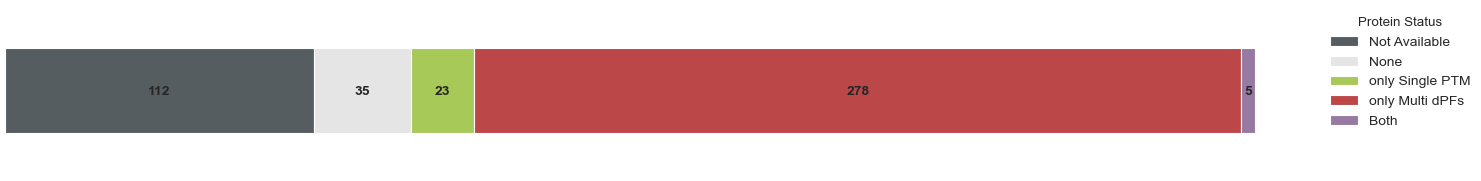

In [205]:
withSingleandMultidPFs = ((protein_info['N(dPFs)'] > 0) & (protein_info['N(PTM)'] > 0)).sum()
onlySinglePTM = ((protein_info['N(dPFs)'] == 0) & (protein_info['N(PTM)'] > 0)).sum()
onlyMultiPTM = ((protein_info['N(dPFs)'] > 0) & (protein_info['N(PTM)'] == 0)).sum()
print(f"Proteins with Single and Multi dPFs: {withSingleandMultidPFs}")
print(f"Proteins with only Single PTM: {onlySinglePTM}")
print(f"Proteins with only Multi dPFs: {onlyMultiPTM}")
print(f"Together: {withSingleandMultidPFs + onlySinglePTM + onlyMultiPTM}")
print(f"Total Proteins: {len(protein_info)}")

plot_data = pd.Series(
    {        
        "Not Available": len(cur_pathway_proteins) - len(protein_info),
        "None": len(protein_info) - (withSingleandMultidPFs + onlySinglePTM + onlyMultiPTM),
        "only Single PTM": onlySinglePTM,
        "only Multi dPFs": onlyMultiPTM,
        "Both": withSingleandMultidPFs,
    }
).to_frame().T
fig, ax = plt.subplots(figsize=(15, 2))
plot_data.plot(
    ax = ax,
    kind="barh",
    stacked=True,
    color={
        "Not Available": "#565d61",
        "None": "#e5e5e5",
        "only Single PTM": "#a7c957",
        "only Multi dPFs": "#bc4749",
        "Both": "#967aa1",
    },
)
plot_pct = plot_data.div(len(cur_pathway_proteins), axis=1) * 100
# Add the percentage as rotated within the bard centered from top (barh with stacked)
for p in ax.patches:
    ax.annotate(
        f"{p.get_width():.0f}",
        (p.get_x() + p.get_width() / 2., p.get_y() + p.get_height() / 2.),
        ha="center",
        va="center",
        xytext=(0, -1),
        textcoords="offset points",
        fontsize=10,
        fontweight="bold"
    )

# Remove all the spines and labels etc.
ax.spines[["top", "right", "left", "bottom"]].set_visible(False)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.legend(
    title="Protein Status",
    loc="upper left",
    bbox_to_anchor=(1, 1),
    frameon=False,
    fontsize=10
)

plt.tight_layout()

# Save the figure
plots.save_figures(
    plt.gcf(),
    filename=f"ProteinGroups_in_{cur_pathway}",
    filepath=figure_path,
    fileformat=figure_formats,
    dpi=figure_dpi,
    transparent=transparet_bg
)

plot_pct

## Example Proteins to Construct

### EPHA 2 - Likely Isoform and Topological Distinction

In [206]:
proteoform_info.loc['O14939']

,PeptideID,proteinDescription,geneName,startpos,endpos,seqLength,trace,Cov%,isCAP,adj.pvalue,TumorRegulation,isSignificant,pfg,Proteoform,isGTPase
Peptide,,,,,,,,,,,,,,,
DFLQLHR,2,Phospholipase D2,PLD2,315,322,933,0,14.1479,False,0.0000,Down,True,1.0000,O14939_1,True
EYVAVEPLATVSPPLAR,3,Phospholipase D2,PLD2,876,893,933,0,14.1479,False,0.2984,Down,False,1.0000,O14939_1,True
FLEDESLLPPLGSK,4,Phospholipase D2,PLD2,909,923,933,0,14.1479,False,0.4805,Down,False,1.0000,O14939_1,True


In [207]:
cur_protein = 'P29317'
# Create a table with the proteins from all methods
cur_table = pd.DataFrame()
for method in dataTypes.keys():
    tmp = testResults[method].copy()
    tmp['Method'] = method
    cur_table = pd.concat([cur_table, tmp[tmp['Protein'] == cur_protein]], axis=0)

cur_table

,N1,N2,log2FC,df_p,df_adjp,eq_lp,eq_ladjp,eq_up,eq_uadjp,eq_p,eq_adjp,comb_p,comb_adjp,log10(pval),log10(adj_pval),Status,Protein,Proteoform,isCAP,Method
1651,10.0000,10.0000,-0.4019,0.0479,0.0727,0.0003,0.0010,0.2951,0.3675,0.2951,0.3675,0.2951,0.3675,-0.5301,-0.4348,Unexplained,P29317,P29317_0,True,mean(all)Proteins
1529,10.0000,10.0000,-0.0539,0.7834,0.8356,0.0086,0.0195,0.0218,0.0340,0.0218,0.0340,0.0218,0.0340,-1.6620,-1.4690,Equivalent,P29317,P29317_0,True,mean(top)Proteins
3060,10.0000,10.0000,-4.5745,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,1.0000,1.0000,0.0000,0.0000,9.2821,8.2897,DownRegulated,P29317,P29317_0,True,dPFProteins
3061,10.0000,10.0000,5.6356,0.0000,0.0000,1.0000,1.0000,0.0000,0.0000,1.0000,1.0000,0.0000,0.0000,10.2075,8.7681,UpRegulated,P29317,P29317_1,True,dPFProteins


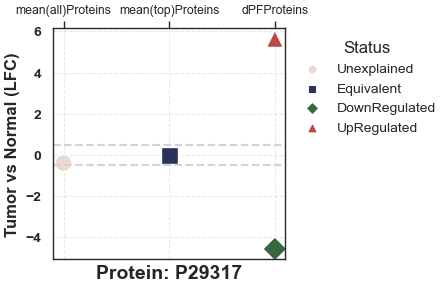

In [208]:
# Create a simple Figure Showing the Proteins
fig, ax = plt.subplots(figsize=(3, 3))
# Use log2FC and Method (Proteoform) and Status
sns.scatterplot(
    ax=ax,
    data=cur_table,
    y='log2FC',
    x='Method',
    hue='Status',
    style='Status',
    palette=test_colors,
    markers=["o", "s", "D", "^", "P"],
    s=150
)
# offset = 0.1
# # Label the Proteoforms
# for i, row in cur_table.iterrows():
#     # If Method is dPFProteins, then use the Proteoform
#     if row['Method'] == 'dPFProteins':
#         s = row['Proteoform']
#         s = "dPF_" + s.split('_')[1]
#         ax.text(
#             x=row['log2FC'] + offset,
#             y=row['Method'],
#             s=s,
#             ha='center',
#             va='center',
#             fontsize=10,
#             fontweight='bold',
#             color='black'
#         )
# Add 0 line
ax.axhline(0.5, color="lightgrey", linestyle="--", linewidth=1.5)
ax.axhline(-0.5, color="lightgrey", linestyle="--", linewidth=1.5)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha="right", fontsize=10, fontweight="bold")
ax.set_title("", fontsize=12, fontweight="bold")
ax.set_ylabel("Tumor vs Normal (LFC)", fontsize=12, fontweight="bold")
ax.set_xlabel(f"Protein: {cur_protein}", fontsize=14, fontweight="bold")
ax.grid("both", linestyle="--", linewidth=0.75, alpha=0.5, color="lightgrey")
# Add the xticks to top
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('bottom')

ax.legend(
    frameon=False,
    fontsize=10,
    title_fontsize=12,
    title="Status",
    loc="upper left",
    bbox_to_anchor=(1, 1)
)

# plt.tight_layout()
# Save the figure
plots.save_figures(
    plt.gcf(),
    filename=f"ProteinStatus_Comparison_{cur_protein}",
    filepath=figure_path,
    fileformat=figure_formats,
    dpi=figure_dpi,
    transparent=transparet_bg
)



### RHOA - Example of Crosslink and Missed Cleavages

In [209]:
proteoform_info.loc['P61586']

,PeptideID,proteinDescription,geneName,startpos,endpos,seqLength,trace,Cov%,isCAP,adj.pvalue,TumorRegulation,isSignificant,pfg,Proteoform,isGTPase
Peptide,,,,,,,,,,,,,,,
DQFPEVYVPTVFENYVADIEVDGK,1,Transforming protein RhoA,RHOA,27,51,193,0,39.8964,True,0.0102,Up,False,1.0000,P61586_1,True
DLRNDEHTR,2,Transforming protein RhoA,RHOA,119,128,193,0,39.8964,True,0.0000,Up,True,1.0000,P61586_1,True
MKQEPVKPEEGR,3,Transforming protein RhoA,RHOA,133,145,193,0,39.8964,True,0.8498,Up,False,1.0000,P61586_1,True
QEPVKPEEGR,4,Transforming protein RhoA,RHOA,135,145,193,1,39.8964,True,0.3215,Down,False,0.0000,P61586_0,True
QEPVKPEEGRDMANR,5,Transforming protein RhoA,RHOA,135,150,193,2,39.8964,True,0.0215,Down,False,0.0000,P61586_0,True
PEEGRDMANR,6,Transforming protein RhoA,RHOA,140,150,193,3,39.8964,True,0.0797,Down,False,0.0000,P61586_0,True
IGAFGYMECSAK,7,Transforming protein RhoA,RHOA,150,162,193,0,39.8964,True,0.4898,Up,False,1.0000,P61586_1,True
DGVREVFEMATR,8,Transforming protein RhoA,RHOA,164,176,193,1,39.8964,True,0.1477,Down,False,0.0000,P61586_0,True


In [210]:
cur_protein = 'P61586'
# Create a table with the proteins from all methods
cur_table = pd.DataFrame()
for method in dataTypes.keys():
    tmp = testResults[method].copy()
    tmp['Method'] = method
    cur_table = pd.concat([cur_table, tmp[tmp['Protein'] == cur_protein]], axis=0)

cur_table

,N1,N2,log2FC,df_p,df_adjp,eq_lp,eq_ladjp,eq_up,eq_uadjp,eq_p,eq_adjp,comb_p,comb_adjp,log10(pval),log10(adj_pval),Status,Protein,Proteoform,isCAP,Method
2382,10.0000,10.0000,0.1417,0.3274,0.3902,0.0139,0.0293,0.0006,0.0011,0.0139,0.0293,0.0139,0.0293,-1.8562,-1.5338,Unexplained,P61586,P61586_0,True,mean(all)Proteins
2225,10.0000,10.0000,0.1510,0.3924,0.4885,0.0339,0.0647,0.0019,0.0039,0.0339,0.0647,0.0339,0.0647,-1.4699,-1.1894,Unexplained,P61586,P61586_0,True,mean(top)Proteins
2259,9.0000,9.0000,-0.1454,0.4606,0.6084,0.0044,0.0128,0.0477,0.0802,0.0477,0.0802,0.0477,0.0802,-1.3219,-1.0961,Unexplained,P61586,P61586_0,True,SpectranoutProteins
4389,10.0000,10.0000,-0.2894,0.0412,0.0565,0.0001,0.0002,0.0587,0.0908,0.0587,0.0908,0.0587,0.0908,-1.2311,-1.0420,Unexplained,P61586,P61586_0,True,dPFProteins
4390,10.0000,10.0000,0.9839,0.0251,0.0358,0.8903,1.0000,0.0014,0.0028,0.8903,1.0000,0.0251,0.0358,1.6010,1.4465,UpRegulated,P61586,P61586_1,True,dPFProteins


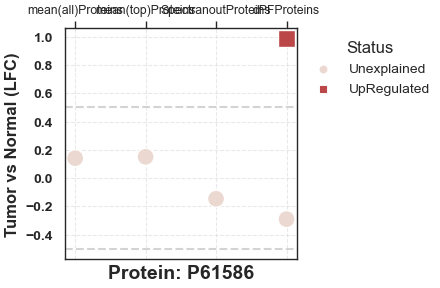

In [211]:
# Create a simple Figure Showing the Proteins
fig, ax = plt.subplots(figsize=(3, 3))
# Use log2FC and Method (Proteoform) and Status
sns.scatterplot(
    ax=ax,
    data=cur_table,
    y='log2FC',
    x='Method',
    hue='Status',
    style='Status',
    palette=test_colors,
    markers=["o", "s", "D", "^", "P"],
    s=150
)
# offset = 0.1
# # Label the Proteoforms
# for i, row in cur_table.iterrows():
#     # If Method is dPFProteins, then use the Proteoform
#     if row['Method'] == 'dPFProteins':
#         s = row['Proteoform']
#         s = "dPF_" + s.split('_')[1]
#         ax.text(
#             x=row['log2FC'] + offset,
#             y=row['Method'],
#             s=s,
#             ha='center',
#             va='center',
#             fontsize=10,
#             fontweight='bold',
#             color='black'
#         )
# Add 0 line
ax.axhline(0.5, color="lightgrey", linestyle="--", linewidth=1.5)
ax.axhline(-0.5, color="lightgrey", linestyle="--", linewidth=1.5)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha="right", fontsize=10, fontweight="bold")
ax.set_title("", fontsize=12, fontweight="bold")
ax.set_ylabel("Tumor vs Normal (LFC)", fontsize=12, fontweight="bold")
ax.set_xlabel(f"Protein: {cur_protein}", fontsize=14, fontweight="bold")
ax.grid("both", linestyle="--", linewidth=0.75, alpha=0.5, color="lightgrey")
# Add the xticks to top
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('bottom')
ax.legend(
    frameon=False,
    fontsize=10,
    title_fontsize=12,
    title="Status",
    loc="upper left",
    bbox_to_anchor=(1, 1)
)

# plt.tight_layout()
# Save the figure
plots.save_figures(
    plt.gcf(),
    filename=f"ProteinStatus_Comparison_{cur_protein}",
    filepath=figure_path,
    fileformat=figure_formats,
    dpi=figure_dpi,
    transparent=transparet_bg
)

